XGBoost for Kaggle's " Liberty Mutual Group. Property Inspection Prediction" competition

### Get the kaggle files

In [1]:
# !kaggle competitions download -c liberty-mutual-group-property-inspection-prediction
# !unzip test.csv.zip
# !unzip train.csv.zip
# !unzip sample_submission.csv.zip
# !rm test.csv.zip
# !rm train.csv.zip
# !rm sample_submission.csv.zip

### Imports

In [2]:
 # Imports
import os
import math

# Scientific Python
import pandas as pd
import numpy as np

# XGBoost
import xgboost as xgb

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

%matplotlib inline

### Read data

In [3]:
# Read data
train = pd.read_csv('train.csv').set_index('Id')
test = pd.read_csv('test.csv').set_index('Id')

In [4]:
# Save the ids for constructing the submission file
test_ids = test.index

In [5]:
len(train)

50999

In [6]:
train.head()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,...,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,N,B,N,B,B,D,...,2,37,1,11,6,Y,N,E,2,2
2,4,16,14,5,H,B,N,B,B,C,...,2,22,1,18,5,Y,Y,E,2,1
3,1,10,10,5,N,K,N,B,B,E,...,6,37,2,14,6,Y,Y,E,6,1
4,1,18,18,5,N,K,N,B,B,E,...,2,25,1,1,6,Y,N,C,2,6
5,1,13,19,5,N,H,N,B,B,E,...,1,22,1,2,7,N,N,E,1,1


In [7]:
# Inspect df
train.dtypes.value_counts()

int64     17
object    16
dtype: int64

In [8]:
# Describe numerical
train.describe()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V10,T1_V13,T1_V14,T2_V1,T2_V2,T2_V4,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V14,T2_V15
count,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000,50999.000000
mean,4.022785,9.722093,12.847585,3.186004,7.020451,13.996255,1.578521,57.580051,12.419616,10.259495,1.948215,33.487755,1.032236,12.493029,4.496520,2.451126,3.484480
std,4.021194,5.167943,6.255743,1.739369,3.595279,4.647499,0.862882,23.499818,4.783411,4.852008,0.800117,5.834038,0.195893,7.314788,1.896717,1.260074,3.076745
min,1.000000,1.000000,1.000000,1.000000,2.000000,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,6.000000,7.000000,2.000000,3.000000,10.000000,1.000000,40.000000,9.000000,6.000000,2.000000,31.000000,1.000000,6.000000,3.000000,2.000000,1.000000
50%,3.000000,9.000000,14.000000,3.000000,8.000000,15.000000,1.000000,56.000000,11.000000,10.000000,2.000000,34.000000,1.000000,14.000000,4.000000,2.000000,2.000000
75%,5.000000,14.000000,18.000000,4.000000,8.000000,20.000000,2.000000,77.000000,15.000000,14.000000,2.000000,40.000000,1.000000,18.000000,6.000000,3.000000,5.000000
max,69.000000,19.000000,24.000000,9.000000,12.000000,20.000000,4.000000,100.000000,39.000000,22.000000,7.000000,40.000000,3.000000,25.000000,7.000000,7.000000,12.000000


In [10]:
# Describe categoridal
train.describe(include='object', exclude='int')

,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,T1_V11,T1_V12,T1_V15,T1_V16,T1_V17,T2_V3,T2_V5,T2_V11,T2_V12,T2_V13
count,50999,50999,50999,50999,50999,50999,50999,50999,50999,50999,50999,50999,50999,50999,50999,50999
unique,8,10,2,4,4,6,12,4,8,18,2,2,6,2,2,5
top,N,K,N,B,B,D,B,B,A,I,N,N,A,Y,N,E
freq,25112,14138,28550,47982,46391,23859,17047,46900,45680,9331,41183,34548,33845,36940,41703,27634


### Preprocess

In [11]:
# Create the training set
y = train.pop('Hazard')
X = train

In [12]:
# Encode categorical values
X = pd.get_dummies(X)
test = pd.get_dummies(test)

print(len(X.columns))
print(len(test.columns))

In [15]:
# Normalize
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
test = pd.DataFrame(scaler.transform(test))

/Users/data/Envs/jupyter_notebooks/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
0,0.777778,0.086957,0.125,0.5,0.666667,0.25,0.353535,0.263158,0.428571,0.166667,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.833333,0.565217,0.500,1.0,0.333333,0.75,0.777778,0.236842,0.761905,0.166667,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.500000,0.391304,0.500,1.0,0.666667,0.25,0.707071,0.526316,0.571429,0.833333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.944444,0.739130,0.500,0.1,0.666667,0.25,0.707071,0.315789,0.666667,0.166667,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.666667,0.782609,0.500,0.5,0.333333,0.25,0.747475,0.236842,0.476190,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0, 0.5, 'Frequency')

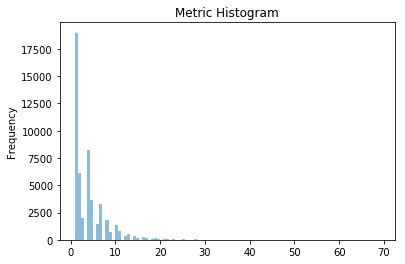

In [42]:
ax = y.plot.hist(bins=100, alpha=0.5)
ax.set_title('Metric Histogram')
ax.set_ylabel('Frequency')

### Train

In [30]:
# Split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [34]:
# Start XGBRegressor
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.5, learning_rate=0.3,
                          max_depth=4, alpha=10, n_estimators=60)

In [35]:
xg_reg

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [58]:
# Fit and predict
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

Text(0, 0.5, 'Frequency')

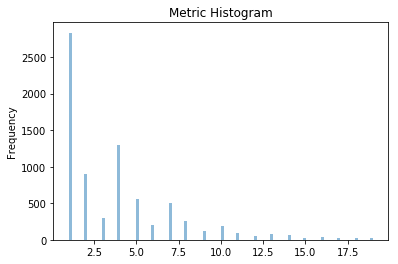

In [48]:
ax = y_test[y_test < 20].plot.hist(bins=100, alpha=0.5)
ax.set_title('Metric Histogram')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

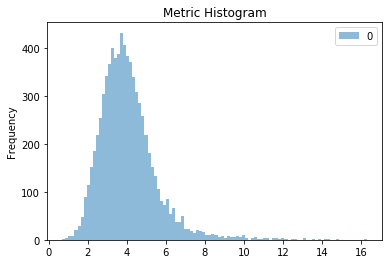

In [46]:
# Inspect predict
ax = pd.DataFrame(preds).plot.hist(bins=100, alpha=0.5)
ax.set_title('Metric Histogram')
ax.set_ylabel('Frequency')

### Predict and submit

In [49]:
# Normalized GINI calculation
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [50]:
gini_normalized(y_test, preds)

0.35066900806023776

In [52]:
preds = xg_reg.predict(test)

In [53]:
submission = pd.DataFrame(test_ids)

In [54]:
submission['Hazard'] = preds

In [55]:
# Save to csv
submission.to_csv('submission.csv', index=False)

In [56]:
# Push to kaggle
# !kaggle competitions submit -f submission.csv -m xgboost liberty-mutual-group-property-inspection-prediction

In [57]:
# View submissions
# !kaggle competitions submissions liberty-mutual-group-property-inspection-prediction